In [1]:
import numpy as np
import pandas as pd

In [2]:
dict_param = np.load('../data/dict_param_all_12.npy', allow_pickle=True).item()

In [3]:
bipartite = dict_param['poi_cbg_visits_list'][0]

In [4]:
bipartite = np.load('../data/bipartite_weight_12.npy', allow_pickle=True).item()

In [5]:
unvax = dict_param['unvax']

In [6]:
bipartite, unvax.shape

(<4310261x214697 sparse matrix of type '<class 'numpy.float64'>'
 	with 532491686 stored elements in Compressed Sparse Row format>,
 (214697,))

In [7]:
upper = bipartite.T @ (bipartite @ unvax)
lower = bipartite.T @ (bipartite @ np.ones(len(unvax)))

In [8]:
key = (0.5, 0.001, 0.0, 100000.0, 720)

In [9]:
import os

state_codes = []

for path in os.listdir('../results/centrality_files/'):
    if 'bipartite_normed_product_' in path:
        try: 
            state_codes.append(int(path.split('_')[-1].split('.')[0]))
        except:
            pass

In [10]:
states = np.array(dict_param['all_unique_cbgs']) // 10000000000

In [11]:
neighbor_vax = np.array(upper / lower)

<ipython-input-11-bae0d092a20f>:1: RuntimeWarning: invalid value encountered in true_divide
  neighbor_vax = np.array(upper / lower)


In [12]:
upper, lower

(array([ 382.60435668,  672.24479125,  420.64136905, ..., 1516.41482118,
        1543.28707723, 2739.25788095]),
 array([ 698.29811372, 1248.68991108,  880.11413281, ..., 3465.76387708,
        3530.27980523, 6286.35101231]))

In [13]:
vaccine_dist = np.load('../results/vax_distribution.npy', allow_pickle=True).item()

In [14]:
vaccine_dist.keys()

dict_keys(['original', 'shuffle', 'reverse_within', 'exchange', 'order'])

In [15]:
upper_exc = bipartite.T @ (bipartite @ vaccine_dist['exchange'])

In [16]:
neighbor_vax_exc = upper_exc / lower

<ipython-input-16-64f7b12e0ef8>:1: RuntimeWarning: invalid value encountered in true_divide
  neighbor_vax_exc = upper_exc / lower


In [17]:
cbg_list = [cbg for cbg in dict_param['cbgs_to_idxs']]

In [18]:
county_list = [cbg // 10000000 for cbg in dict_param['cbgs_to_idxs']]

In [19]:
import pandas as pd

data = []

centrality = [0] * len(dict_param['unvax'])

for i in range(len(dict_param['unvax'])):
    data.append({
        'cbg': cbg_list[i],
        'state': states[i],
        'county': county_list[i],
        'centrality': lower[i], 
        'vax': 1 - dict_param['unvax'][i],
        'neighbor_vax': 1 - neighbor_vax[i],
#         'vax_group': int((1 - dict_param['unvax'][i]) * 20),
        'vax_exchange': 1 - vaccine_dist['exchange'][i],
        'neighbor_vax_exchange': 1 - neighbor_vax_exc[i],
        'cbg_size': dict_param['cbg_sizes'][i]
    })

data = pd.DataFrame.from_dict(data)

In [20]:
data.groupby('county')['centrality'].sum()

county
1001     117112.193453
1003     558637.336117
1005      20267.280262
1007      36849.073670
1009     127672.980962
             ...      
56037     17057.379743
56039     13776.943073
56041      9097.472813
56043      2442.470190
56045      2028.391822
Name: centrality, Length: 3105, dtype: float64

In [21]:
data['vax_times_cbg'] = data['vax'] * data['cbg_size']

In [22]:
data['log_centrality'] = np.log10(data['centrality'] + 1.0)

In [23]:
data_avg = data.groupby('state')[['log_centrality', 'vax', 'neighbor_vax']].mean().reset_index()

In [24]:
data_avg.columns = ['state', 'log_centrality_avg', 'vax_avg', 'neighbor_vax_avg']

In [25]:
data_std = data.groupby('state')[['log_centrality', 'vax', 'neighbor_vax']].std().reset_index()

In [26]:
data_std.columns = ['state', 'log_centrality_std', 'vax_std', 'neighbor_vax_std']

In [27]:
data = data.merge(data_std, on='state')

In [30]:
data = data.merge(data_avg, on='state')

In [31]:
data['z_vax'] = (data['vax'] - data['vax_avg']) / data['vax_std']
data['z_log_centrality'] = (data['log_centrality'] - data['log_centrality_avg']) / data['log_centrality_std']
data['z_neighbor_vax'] = (data['neighbor_vax'] - data['neighbor_vax_avg']) / data['neighbor_vax_std']

In [32]:
data.dropna(inplace=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


<Figure size 576x576 with 0 Axes>

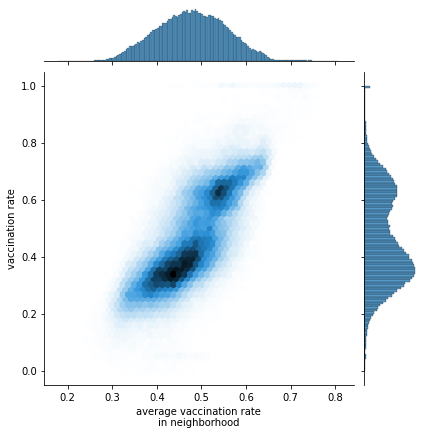

In [35]:
plt.figure(figsize=(8, 8))

sns.jointplot(data=data, 
             x='neighbor_vax',
             y='vax',
             kind='hex'
            )

# plt.title('original distribution')
plt.ylabel('vaccination rate')
plt.xlabel('average vaccination rate\nin neighborhood')
plt.savefig('../results/homophily_metric.pdf')

<Figure size 576x576 with 0 Axes>

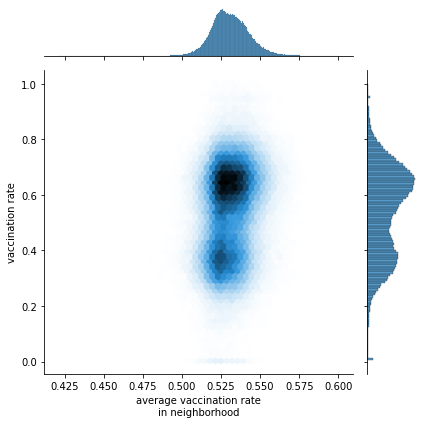

In [39]:
plt.figure(figsize=(8, 8))

sns.jointplot(data=data, 
             x='neighbor_vax_exchange',
             y='vax_exchange',
             kind='hex'
            )

plt.ylabel('vaccination rate')
plt.xlabel('average vaccination rate\nin neighborhood')
# plt.title('exchange counterfactual')
plt.tight_layout()
plt.savefig('../results/homophily_metric_exchange.pdf')

In [41]:
def decile(x):
    x = int(x*10)+1
    if x==11:
        x=10
    return x

rankings = data[['z_log_centrality']].rank(pct=True).applymap(decile)

data['decile_z_log_centrality'] = rankings

rankings = data[['z_neighbor_vax']].rank(pct=True).applymap(decile)

data['decile_z_neighbor_vax'] = rankings


rankings = data[['log_centrality']].rank(pct=True).applymap(decile)

data['decile_log_centrality'] = rankings


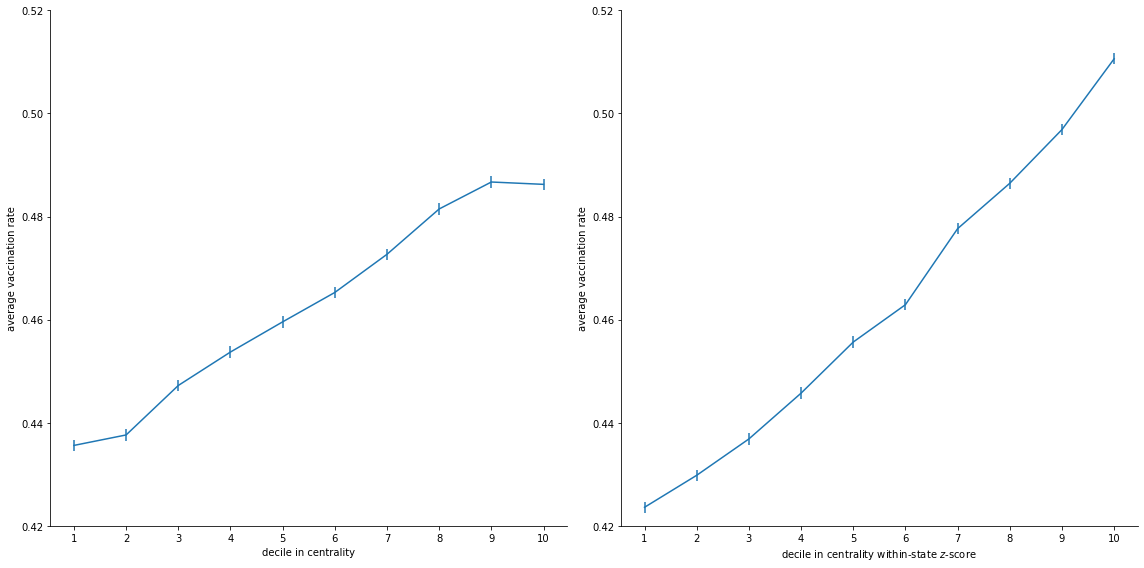

In [42]:
plt.figure(figsize=(16, 8))

plt.subplot(121)

plt.errorbar(
    range(10),
    data.groupby('decile_log_centrality')['vax'].mean(),
    yerr=data.groupby('decile_log_centrality')['vax'].std()/np.sqrt(data.groupby('decile_z_log_centrality')['vax'].count()-1)
)

plt.ylim(0.42, 0.52)
plt.xlabel('decile in centrality')
plt.ylabel('average vaccination rate')
plt.xticks(range(10), range(1, 11))

plt.subplot(122)

plt.errorbar(
    range(10),
    data.groupby('decile_z_log_centrality')['vax'].mean(),
    yerr=data.groupby('decile_z_log_centrality')['vax'].std()/np.sqrt(data.groupby('decile_z_log_centrality')['vax'].count()-1)
)

plt.ylim(0.42, 0.52)
plt.xlabel('decile in centrality within-state $z$-score')
plt.ylabel('average vaccination rate')
plt.xticks(range(10), range(1, 11))

plt.tight_layout()
sns.despine()

plt.savefig('../results/decile_centrality.pdf')